In [16]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

%matplotlib inline


In [17]:
BASE_DIR = "./dataset/"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "fairface-img-margin50-trainval/train")
VALIDATION_IMG_DIR = os.path.join(BASE_DIR, "fairface-img-margin50-trainval/val")
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "fairface_label_train.csv")
VALIDATION_CSV_PATH = os.path.join(BASE_DIR, "fairface_label_val.csv")

train_df = pd.read_csv(TRAIN_CSV_PATH)
val_df = pd.read_csv(VALIDATION_CSV_PATH)

In [18]:
train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [19]:
val_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [20]:
class FairFaceDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

        # age列（文字列）をカテゴリに変換するためのマッピング例
        # FairFace の age 列は '0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+' など
        self.age_classes = [
            "0-2",
            "3-9",
            "10-19",
            "20-29",
            "30-39",
            "40-49",
            "50-59",
            "60-69",
            "70+",
        ]
        self.age_to_idx = {a: i for i, a in enumerate(self.age_classes)}

        # gender列（male/female）を二値(0,1)にマッピング
        self.gender_to_idx = {"male": 0, "female": 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["file"])

        # 画像読み込み
        image = Image.open(img_path).convert("RGB")

        # age, gender を数値に変換
        age_label = self.age_to_idx[row["age"]]
        gender_label = self.gender_to_idx[row["gender"]]

        # transform (データ拡張やサイズ正規化など)
        if self.transform:
            image = self.transform(image)

        return image, age_label, gender_label

In [21]:
train_dataset = FairFaceDataset(train_df, TRAIN_IMG_DIR, transform=train_transform)
val_dataset = FairFaceDataset(val_df, VALIDATION_IMG_DIR, transform=val_transform)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [24]:
class AgeGenderModel(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(AgeGenderModel, self).__init__()
        # torchvision の pre-trained ResNet18をバックボーンに使用
        self.backbone = models.resnet18(pretrained=True)
        # 最終FC層を取り外して特徴ベクトルを抽出しやすくする
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # 年齢層用と性別用の2つの全結合層
        self.age_fc = nn.Linear(in_features, num_age_classes)
        self.gender_fc = nn.Linear(in_features, num_gender_classes)

    def forward(self, x):
        feats = self.backbone(x)             # [batch_size, in_features]
        age_out = self.age_fc(feats)         # [batch_size, num_age_classes]
        gender_out = self.gender_fc(feats)   # [batch_size, num_gender_classes]
        return age_out, gender_out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeGenderModel().to(device)


/Users/takumi.wada/Documents/devJourney/fairface-gender-age-clothing-model/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/takumi.wada/Documents/devJourney/fairface-gender-age-clothing-model/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted Age Range: 10-19
Predicted Gender: male


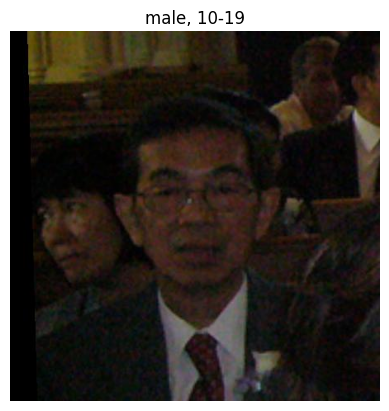

In [25]:
# 任意の画像を読み込み
test_image_path = os.path.join("dataset/fairface-img-margin125-trainval/train/1.jpg")
img_pil = Image.open(test_image_path).convert("RGB")

# 前処理
img_input = val_transform(img_pil).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    age_out, gender_out = model(img_input)
    age_pred = age_out.argmax(dim=1).item()
    gender_pred = gender_out.argmax(dim=1).item()

age_label_str = train_dataset.age_classes[age_pred]
gender_label_str = list(train_dataset.gender_to_idx.keys())[list(train_dataset.gender_to_idx.values()).index(gender_pred)]

print("Predicted Age Range:", age_label_str)
print("Predicted Gender:", gender_label_str)

# 画像表示
plt.imshow(img_pil)
plt.title(f"{gender_label_str}, {age_label_str}")
plt.axis('off')
plt.show()
